# Notebook for activation extraction protocol investigation

In this notebook we investigate how activation from each model should be retrieved.
Several factors were identified:
    - context
    - normalization
    - dimensionality reduction

In [2]:
import warnings
warnings.simplefilter(action='ignore')

import os
import gc
import glob
import itertools
from tqdm import tqdm
from itertools import combinations
from joblib import Parallel, delayed

import umap
import scipy
import hdbscan
import nistats
import numpy as np
import pandas as pd
import pingouin as pg
from sklearn import manifold
import statsmodels.api as sm 
from statsmodels.formula.api import ols   
from sklearn.decomposition import PCA, FastICA
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import AgglomerativeClustering, KMeans

%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nibabel as nib
import nilearn
from nilearn.image import load_img, mean_img, index_img, threshold_img, math_img, smooth_img, new_img_like
from nilearn.input_data import NiftiMapsMasker, NiftiMasker, NiftiLabelsMasker, MultiNiftiMasker
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting
from nilearn import datasets
from scipy.stats import norm
from nilearn.surface import vol_to_surf

import utils 
import reporting
from logger import Logger
from linguistics_info import load_surnames, load_syntactic_roi, load_language_roi

### Paths

In [3]:
language = 'english'

In [4]:
PROJECT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/"
OUTPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/{language}"
INPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{language}"
FMRIDATA_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/fMRI/{language}"
MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/ROI_masks/global_masker_95%_{language}"
ALL_MASKS_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/ROI_masks/"
SAVING_FOLDER = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/{language}"
TMP_FOLDER = f"/home/ap259944/tmp"

In [5]:
#PROJECT_PATH = f"/Users/alexpsq/Code/Parietal/maps"
#INPUT_PATH = f"/Users/alexpsq/Code/Parietal/data/stimuli-representations/english"

### Atlas

In [6]:
atlas_maps, labels = reporting.load_atlas()

## Normalization

Here we look at the impact of normalization over fMRI BOLD signal model prediction.

Here we will only say that among BERT and GPT-2 activations, we found high variance activations for GPT-2 and low-variance activations for BERT.
GPT-2's regression performances were highly impacted by scaling anterior to the pipeline, while BERT wasn't.

## Context

Here we perform ANOVA analysis 

In [7]:
model_names = [
    'bert-base-cased_pre-0_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-0_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'gpt2_pre-0_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-1_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-2_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-5_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-10_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-15_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-0_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
    'gpt2_pre-1_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
    'gpt2_pre-2_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
    'gpt2_pre-5_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
    'gpt2_pre-10_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
    'gpt2_pre-15_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
     'roberta-base_pre-0_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'roberta-base_pre-5_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'roberta-base_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'roberta-base_pre-20_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'roberta-base_pre-15_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'roberta-base_pre-1_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'roberta-base_pre-10_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
   
]

In [8]:
anova_context = reporting.prepare_data_for_anova(
    model_names, 
    atlas_maps, 
    labels, 
    MASKER_PATH,
    object_of_interest='Pearson_coeff', 
    language='english',
    OUTPUT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english'
    )

	Looping through labeled masks...


100%|██████████| 97/97 [18:56<00:00, 11.71s/it]


In [8]:
saving_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/anovas/'
utils.check_folder(saving_folder)

In [11]:
anova_context.to_csv(os.path.join(saving_folder, 'anova_context.csv'), index=False)

In [9]:
anova_context = pd.read_csv(os.path.join(saving_folder, 'anova_context.csv'))

for name in ['bert', 'gpt2']:
    for norm in ['norm-inf', 'norm-2']:
        data_tmp = anova_context[anova_context.apply(lambda x: name in x['model'], axis=1)].reset_index(drop=True)
        data_tmp = data_tmp[data_tmp.apply(lambda x: norm in x['model'], axis=1)].reset_index(drop=True)
        anova_table_context = pg.rm_anova(data=data_tmp, dv='Pearson_coeff_3rd_quartile', within=['ROI', 'model'], subject='subject', correction=True)

        #model_context = ols('Pearson_coeff_3rd_quartile ~ C(model) + C(ROI) + C(model):C(ROI)', data=data_tmp).fit()  
        #anova_table_context = sm.stats.anova_lm(model_context, typ=2)
        print('------- Model: ', name, '-', norm, ' - Context Analysis -------')
        print()
        print(anova_table_context)
        print('\n\n')

------- Model:  bert - norm-inf  - Context Analysis -------

        Source         SS  ddof1  ddof2        MS          F          p-unc  \
0          ROI  67.148396     96   4800  0.699462  99.552568   0.000000e+00   
1        model   0.079068      7    350  0.011295   9.434741   9.865699e-11   
2  ROI * model   0.196086    672  33600  0.000292   3.913300  3.774771e-217   

      p-GG-corr       np2       eps  
0  2.556845e-96  0.665669  0.089083  
1  4.810323e-06  0.158741  0.461939  
2  1.266911e-04  0.072585  0.012595  



------- Model:  bert - norm-2  - Context Analysis -------

        Source         SS  ddof1  ddof2        MS           F         p-unc  \
0          ROI  63.507755     96   4800  0.661539  100.458582  0.000000e+00   
1        model   0.178260      7    350  0.025466   18.422062  7.069602e-21   
2  ROI * model   0.319543    672  33600  0.000476    6.204073  0.000000e+00   

       p-GG-corr       np2       eps  
0  9.093332e-102  0.667683  0.093714  
1   8.099790e

100%|██████████| 97/97 [00:54<00:00,  1.77it/s]


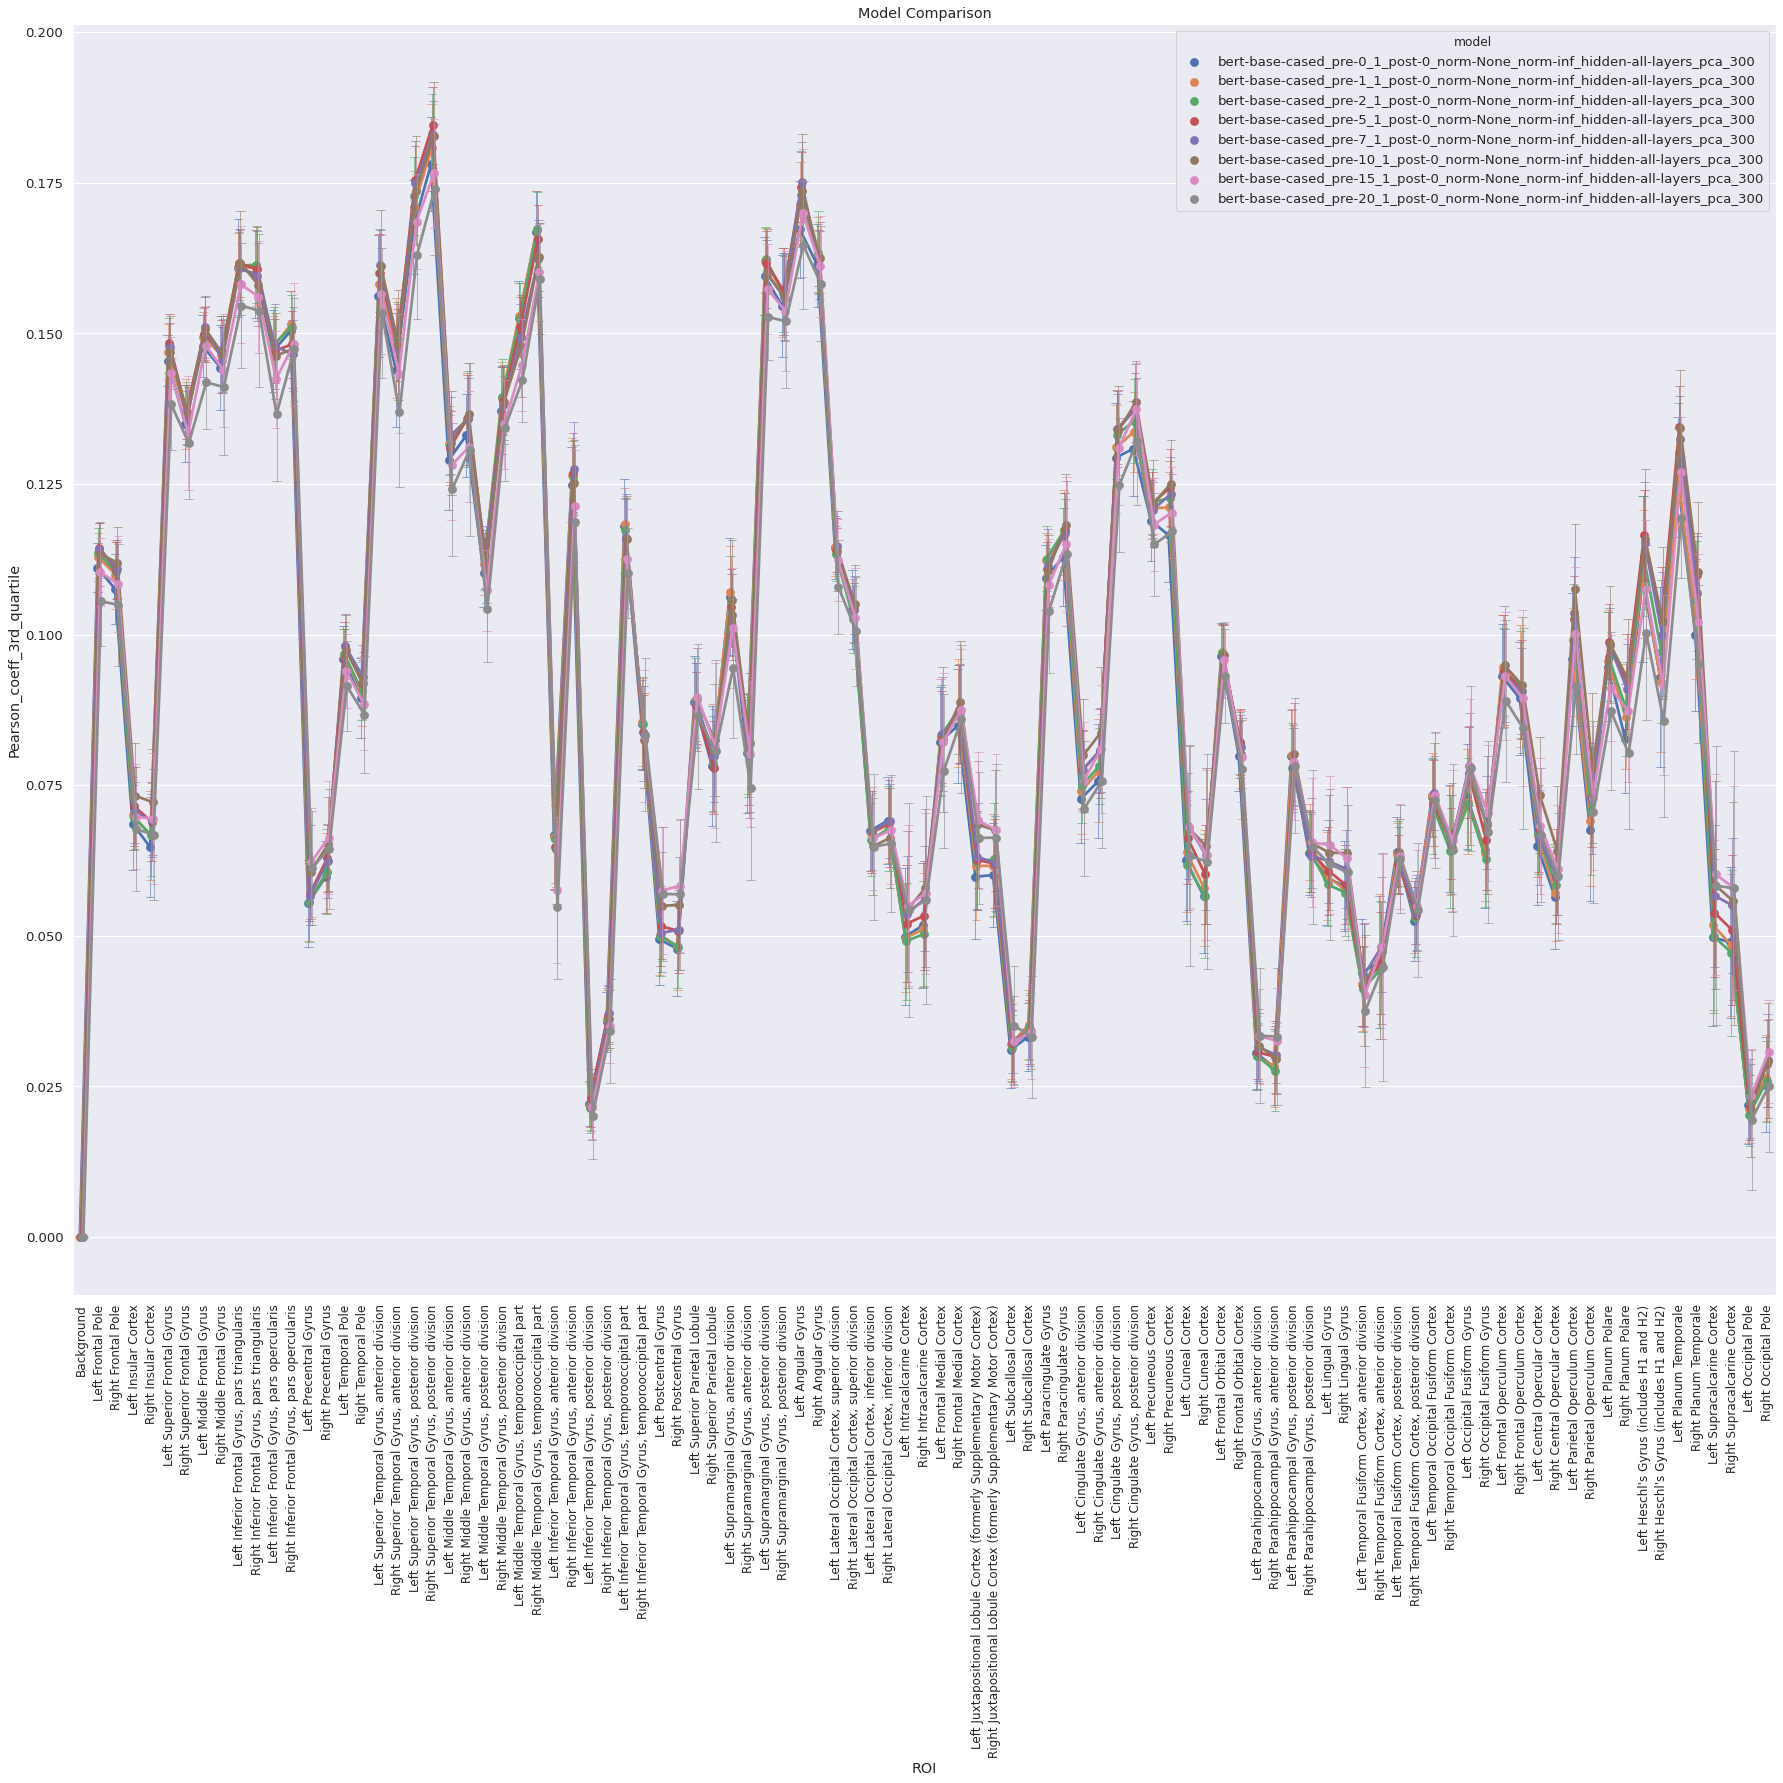

100%|██████████| 97/97 [00:52<00:00,  1.85it/s]


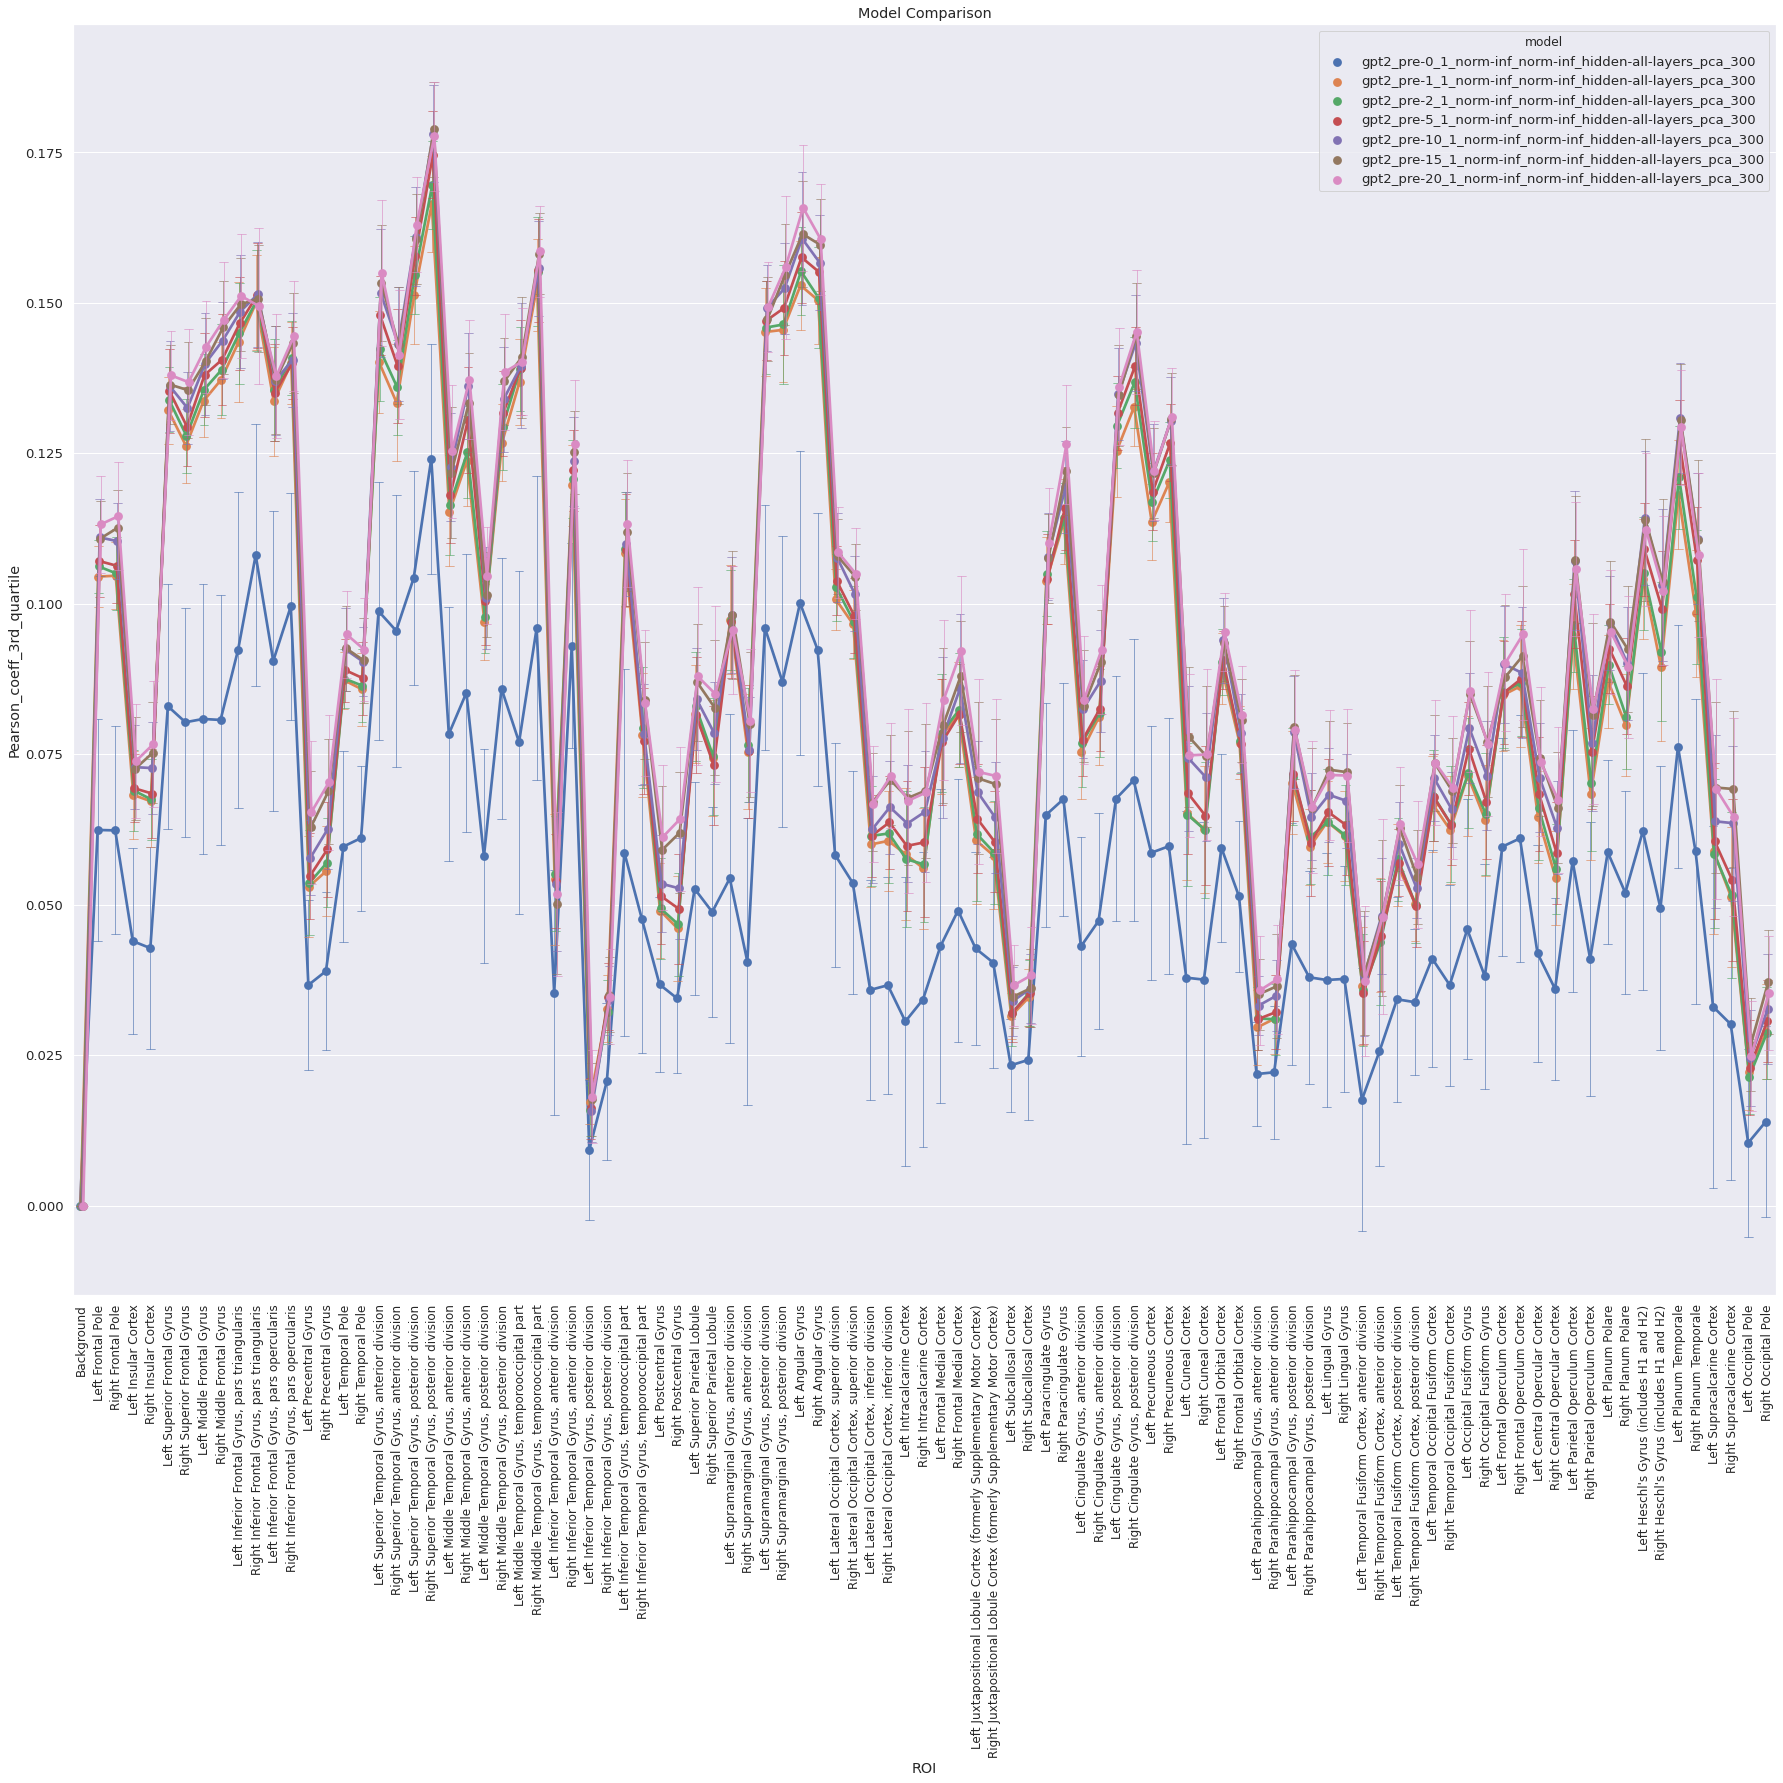

In [11]:
comparison = anova_context.copy()
for name in ['bert', 'gpt2']:
    norm = 'norm-inf'
    data_tmp = comparison[comparison.apply(lambda x: name in x['model'], axis=1)].reset_index(drop=True)
    data_tmp = data_tmp[data_tmp.apply(lambda x: norm in x['model'], axis=1)].reset_index(drop=True)
    for roi in tqdm(data_tmp['ROI'].unique()):
        mean_global = np.mean(data_tmp[data_tmp['ROI']==roi]['Pearson_coeff_3rd_quartile'].values)
        for subject in data_tmp['subject'].unique():
            tmp = mean_global - np.mean(data_tmp[(data_tmp['ROI']==roi) & (data_tmp['subject']==subject)]['Pearson_coeff_3rd_quartile'].values)
            data_tmp.loc[(data_tmp['ROI']==roi) & (data_tmp['subject']==subject),'Pearson_coeff_3rd_quartile'] += tmp

    plt.figure(figsize=((25,25)))
    sns.set(context='notebook', font_scale=1.2)
    colors = ['r', 'g', 'blue', 'black']
    #for index, model in enumerate(anova_comparison['model'].unique()):
    #    sns.pointplot(data=anova_comparison[anova_comparison['model']==model], x='ROI', y='Pearson_coeff_3rd_quartile', alpha=0.7, errwidth=0.6, capsize=.1, ci='sd', color=colors[index])
    sns.pointplot(data=data_tmp, x='ROI', y='Pearson_coeff_3rd_quartile', hue='model', dodge=True, alpha=0.7, errwidth=0.6, capsize=0.5, ci='sd')

    _ = plt.title('Model Comparison')
    ax = plt.axes()
    ax.tick_params(axis='x', labelsize=12, rotation=90)
    #plt.legend([model], ncol=1, bbox_to_anchor=(0,0,1,1), fontsize=10)
    #plt.legend(anova_comparison['model'].unique(), ncol=1, bbox_to_anchor=(0,0,1,1), fontsize=10)

    plt.tight_layout()
    plt.show()

## Dimensionality reduction

We investigate different dimensionality reduction technics (PCA, ICA, UMAP, Agglomerative Clustering).
We found that PCA and ICA had the best results, with a very sligh advantage of PCA which is also a lot faster.

In [13]:
model_names = [
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_50',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_100',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_150',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_500',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_1000',
    
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_umap_10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_umap_50',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_umap_100',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_umap_150',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_umap_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_umap_500',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_umap_1000',
    
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_ica_300',
    
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_similarity_cluster_300',
]

sub_model_names = [
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_umap_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_ica_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_similarity_cluster_300',

]

sub_model_names_pca = [
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_50',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_100',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_150',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_500',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_1000',
]
sub_model_names_umap = [
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_umap_10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_umap_50',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_umap_100',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_umap_150',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_umap_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_umap_500',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_umap_1000',
]

In [14]:
anova_reduction = reporting.prepare_data_for_anova(
    model_names, 
    atlas_maps, 
    labels, 
    MASKER_PATH,
    object_of_interest='Pearson_coeff', 
    language='english',
    OUTPUT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english'
    )

	Looping through labeled masks...


100%|██████████| 97/97 [15:35<00:00,  9.64s/it]


In [14]:
saving_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/anovas/'
utils.check_folder(saving_folder)

In [16]:
anova_reduction.to_csv(os.path.join(saving_folder, 'anova_reduction.csv'), index=False)

In [15]:
anova_reduction = pd.read_csv(os.path.join(saving_folder, 'anova_reduction.csv'))

In [16]:
data_tmp = anova_reduction[anova_reduction.apply(lambda x: x['model'] in sub_model_names, axis=1)].reset_index(drop=True)
anova_table_reduction = pg.rm_anova(data=data_tmp, dv='Pearson_coeff_3rd_quartile', within=['ROI', 'model'], subject='subject', correction=True)
print('------- Dimensionality Reduction Analysis - Method comparison -------')
print()
print(anova_table_reduction)
print('\n\n')

data_tmp = anova_reduction[anova_reduction.apply(lambda x: x['model'] in sub_model_names_pca, axis=1)].reset_index(drop=True)
anova_table_reduction = pg.rm_anova(data=data_tmp, dv='Pearson_coeff_3rd_quartile', within=['ROI', 'model'], subject='subject', correction=True)
print('------- Dimensionality Reduction Analysis - PCA -------')
print()
print(anova_table_reduction)
print('\n\n')

data_tmp = anova_reduction[anova_reduction.apply(lambda x: x['model'] in sub_model_names_umap, axis=1)].reset_index(drop=True)
anova_table_reduction = pg.rm_anova(data=data_tmp, dv='Pearson_coeff_3rd_quartile', within=['ROI', 'model'], subject='subject', correction=True)
print('------- Dimensionality Reduction Analysis - UMAP -------')
print()
print(anova_table_reduction)
print('\n\n')

------- Dimensionality Reduction Analysis - Method comparison -------

        Source         SS  ddof1  ddof2        MS           F         p-unc  \
0          ROI  25.439332     96   4800  0.264993   99.262577  0.000000e+00   
1        model   2.172854      3    150  0.724285  130.339351  1.376242e-41   
2  ROI * model   1.572085    288  14400  0.005459   28.726837  0.000000e+00   

      p-GG-corr       np2       eps  
0  1.859432e-98  0.665020  0.091293  
1  7.899018e-18  0.722745  0.391773  
2  9.328495e-32  0.364893  0.024763  



------- Dimensionality Reduction Analysis - PCA -------

        Source         SS  ddof1  ddof2        MS           F          p-unc  \
0          ROI  50.806600     96   4800  0.529235   91.922883   0.000000e+00   
1        model   3.044178      6    300  0.507363  213.386242  4.313431e-105   
2  ROI * model   1.016185    576  28800  0.001764   30.076032   0.000000e+00   

      p-GG-corr       np2       eps  
0  4.396067e-98  0.647696  0.095697  
1  

100%|██████████| 97/97 [00:51<00:00,  1.90it/s]


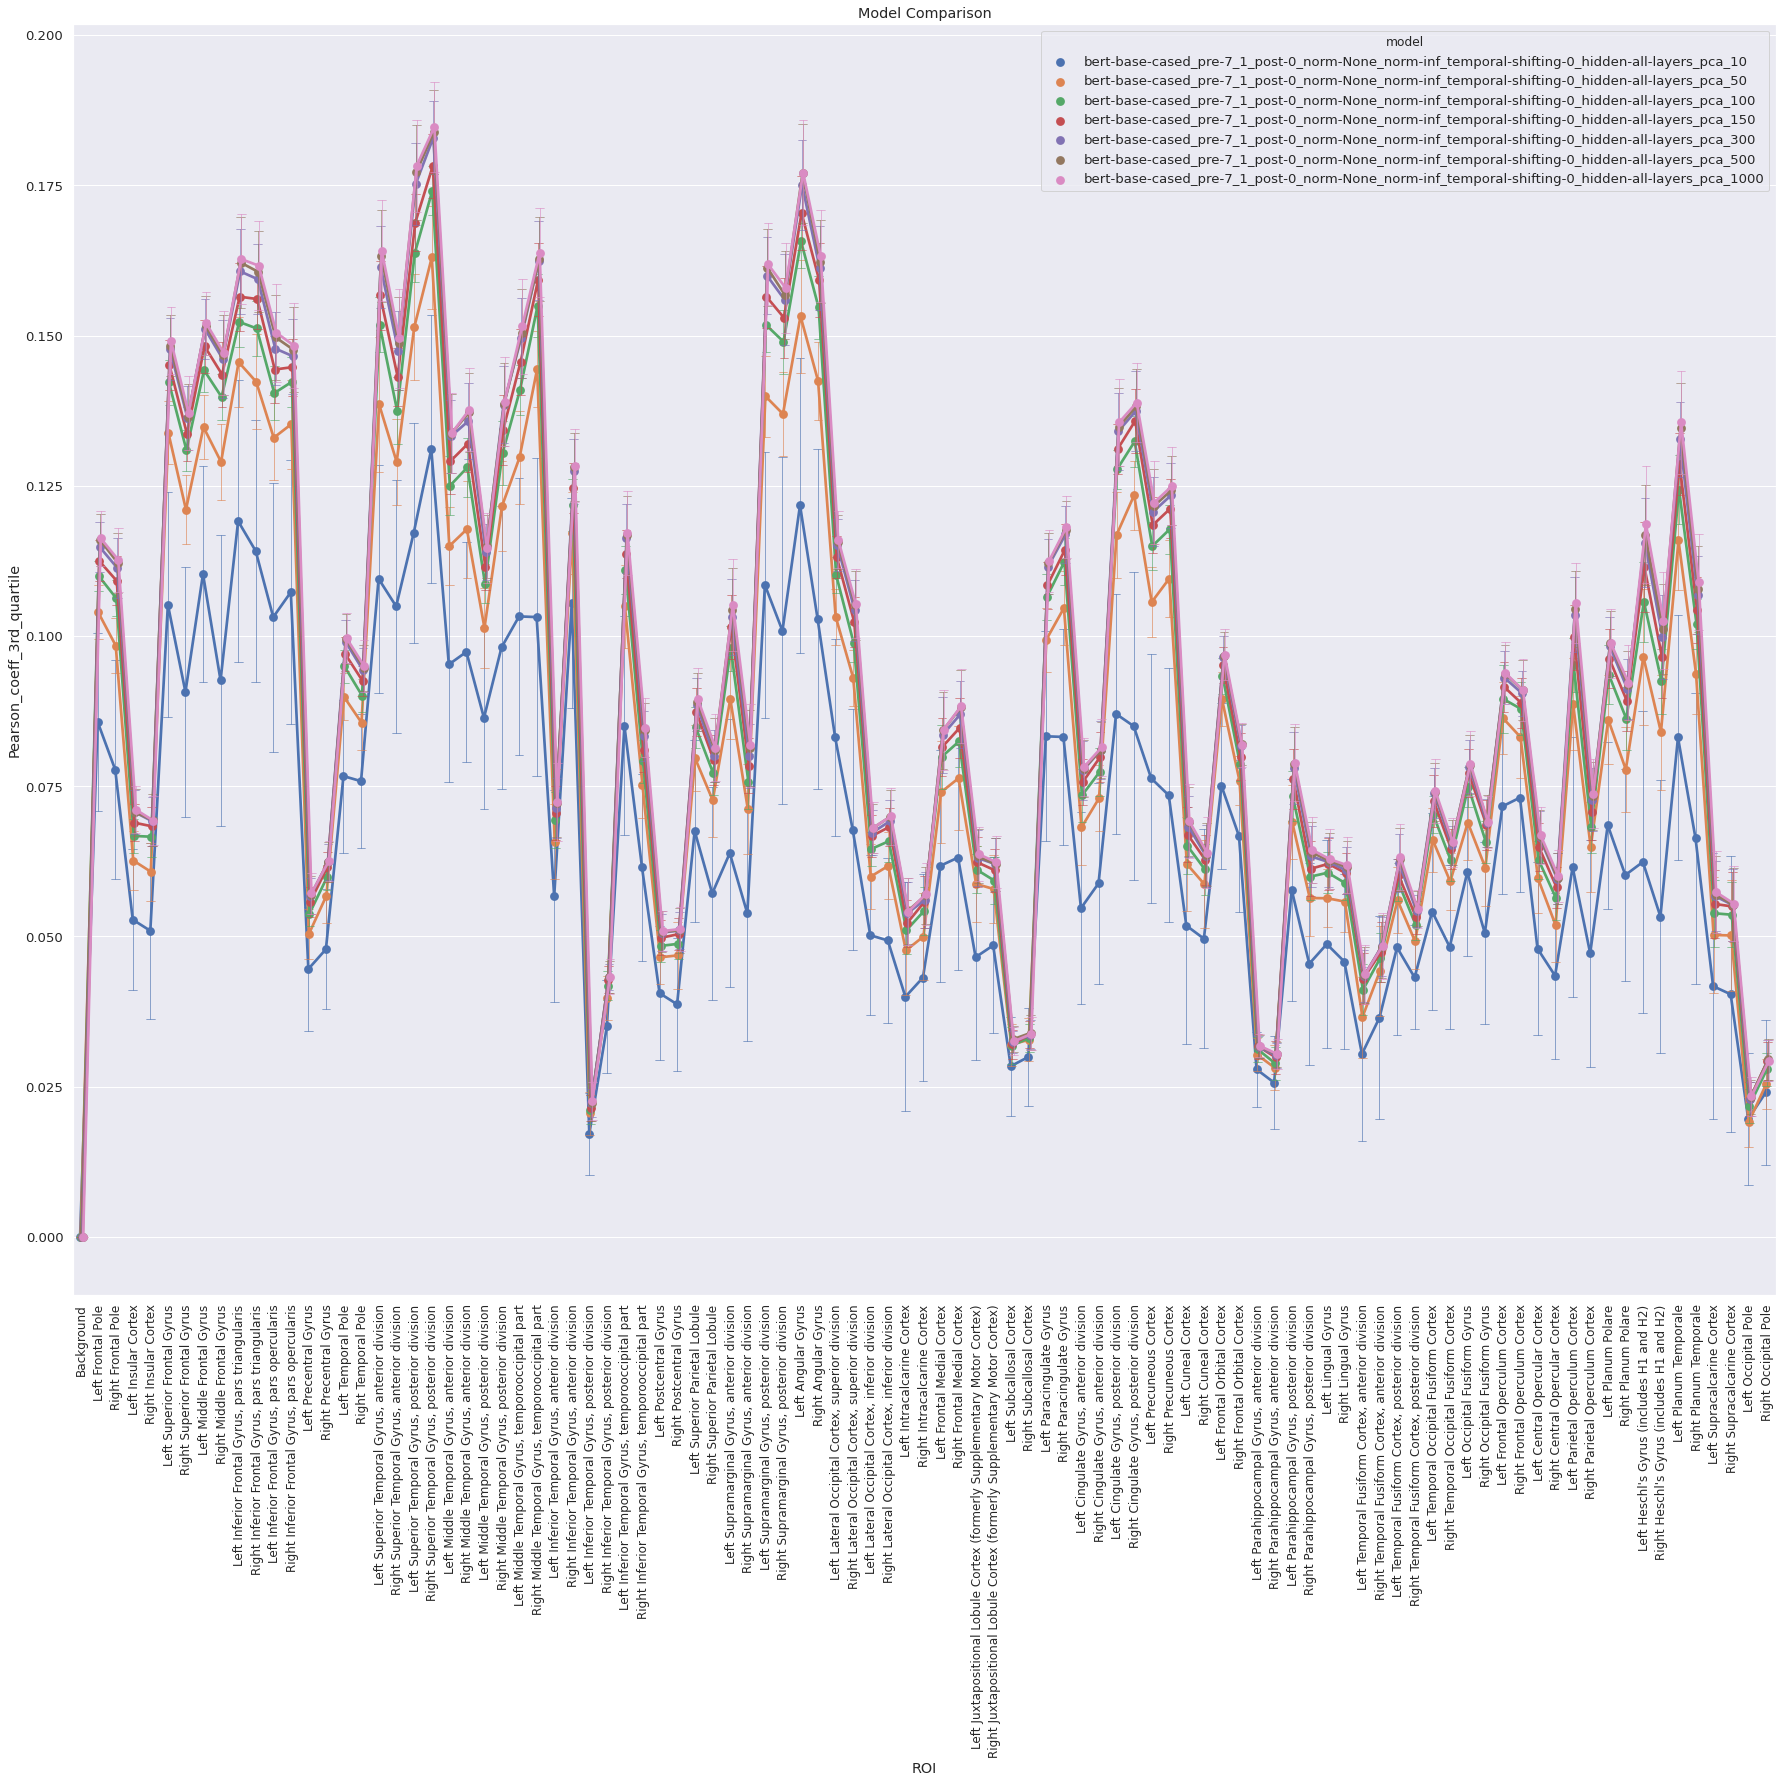

100%|██████████| 97/97 [00:52<00:00,  1.84it/s]


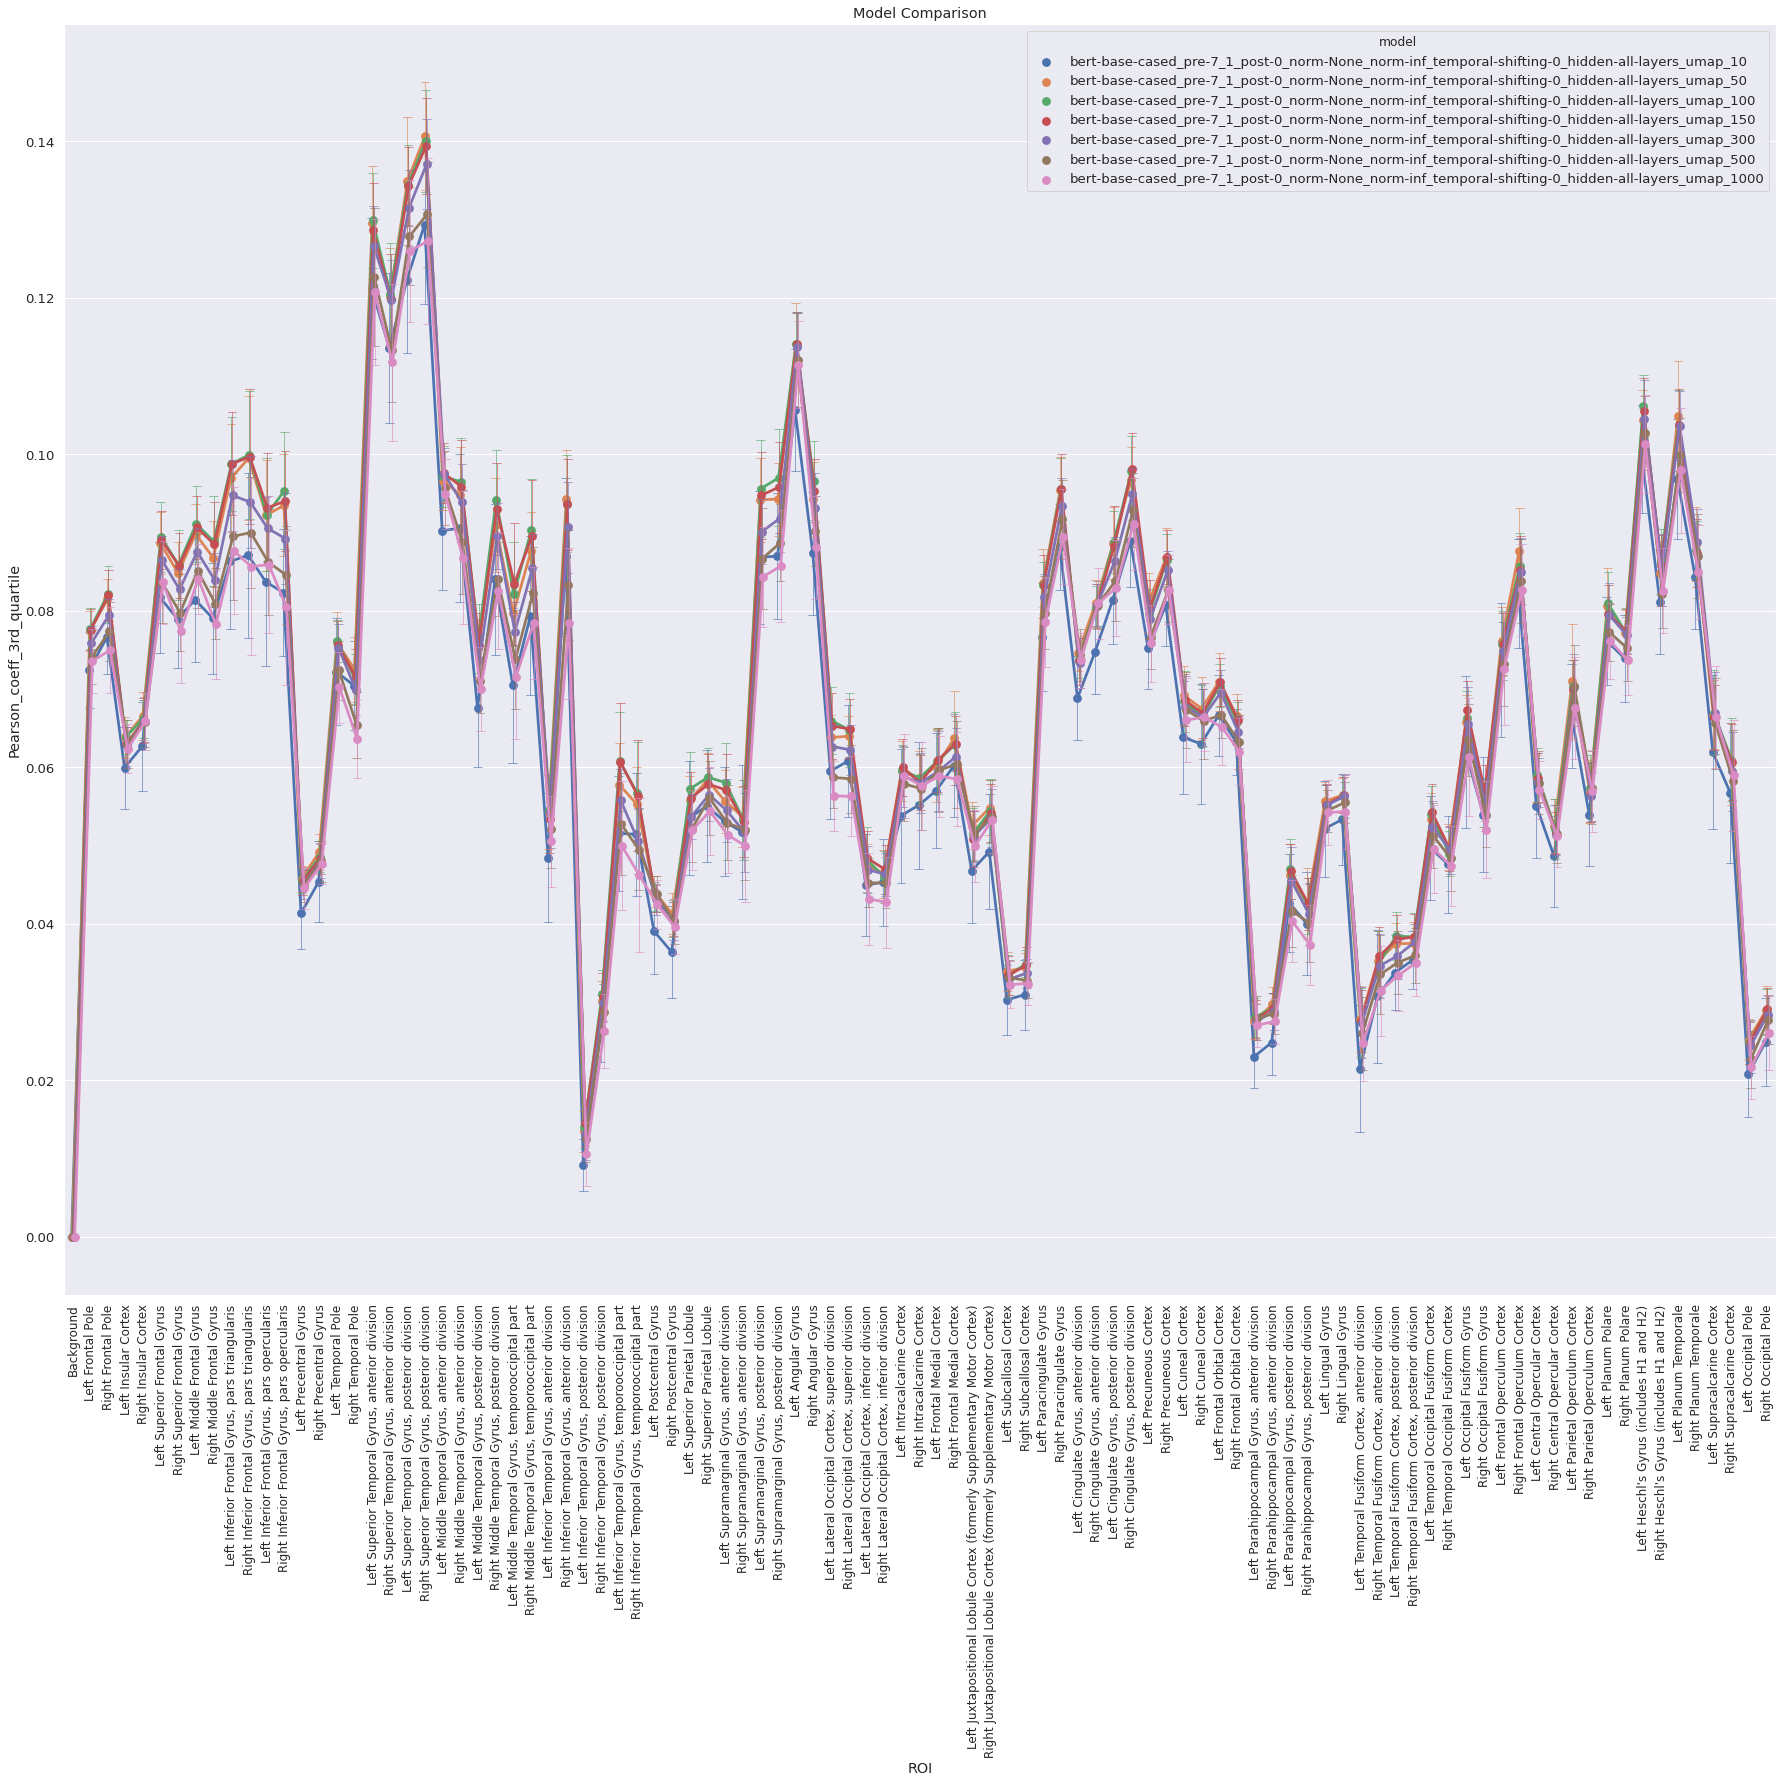

In [16]:
comparison = anova_reduction.copy()
for name in ['pca', 'umap']:
    data_tmp = comparison[comparison.apply(lambda x: name in x['model'], axis=1)].reset_index(drop=True)
    #data_tmp = data_tmp[data_tmp.apply(lambda x: norm in x['model'], axis=1)].reset_index(drop=True)
    for roi in tqdm(data_tmp['ROI'].unique()):
        mean_global = np.mean(data_tmp[data_tmp['ROI']==roi]['Pearson_coeff_3rd_quartile'].values)
        for subject in data_tmp['subject'].unique():
            tmp = mean_global - np.mean(data_tmp[(data_tmp['ROI']==roi) & (data_tmp['subject']==subject)]['Pearson_coeff_3rd_quartile'].values)
            data_tmp.loc[(data_tmp['ROI']==roi) & (data_tmp['subject']==subject),'Pearson_coeff_3rd_quartile'] += tmp

    plt.figure(figsize=((25,25)))
    sns.set(context='notebook', font_scale=1.2)
    colors = ['r', 'g', 'blue', 'black']
    #for index, model in enumerate(anova_comparison['model'].unique()):
    #    sns.pointplot(data=anova_comparison[anova_comparison['model']==model], x='ROI', y='Pearson_coeff_3rd_quartile', alpha=0.7, errwidth=0.6, capsize=.1, ci='sd', color=colors[index])
    sns.pointplot(data=data_tmp, x='ROI', y='Pearson_coeff_3rd_quartile', hue='model', dodge=True, alpha=0.7, errwidth=0.6, capsize=0.5, ci='sd')

    _ = plt.title('Model Comparison')
    ax = plt.axes()
    ax.tick_params(axis='x', labelsize=12, rotation=90)
    #plt.legend([model], ncol=1, bbox_to_anchor=(0,0,1,1), fontsize=10)
    #plt.legend(anova_comparison['model'].unique(), ncol=1, bbox_to_anchor=(0,0,1,1), fontsize=10)

    plt.tight_layout()
    plt.show()

100%|██████████| 97/97 [01:24<00:00,  1.15it/s]


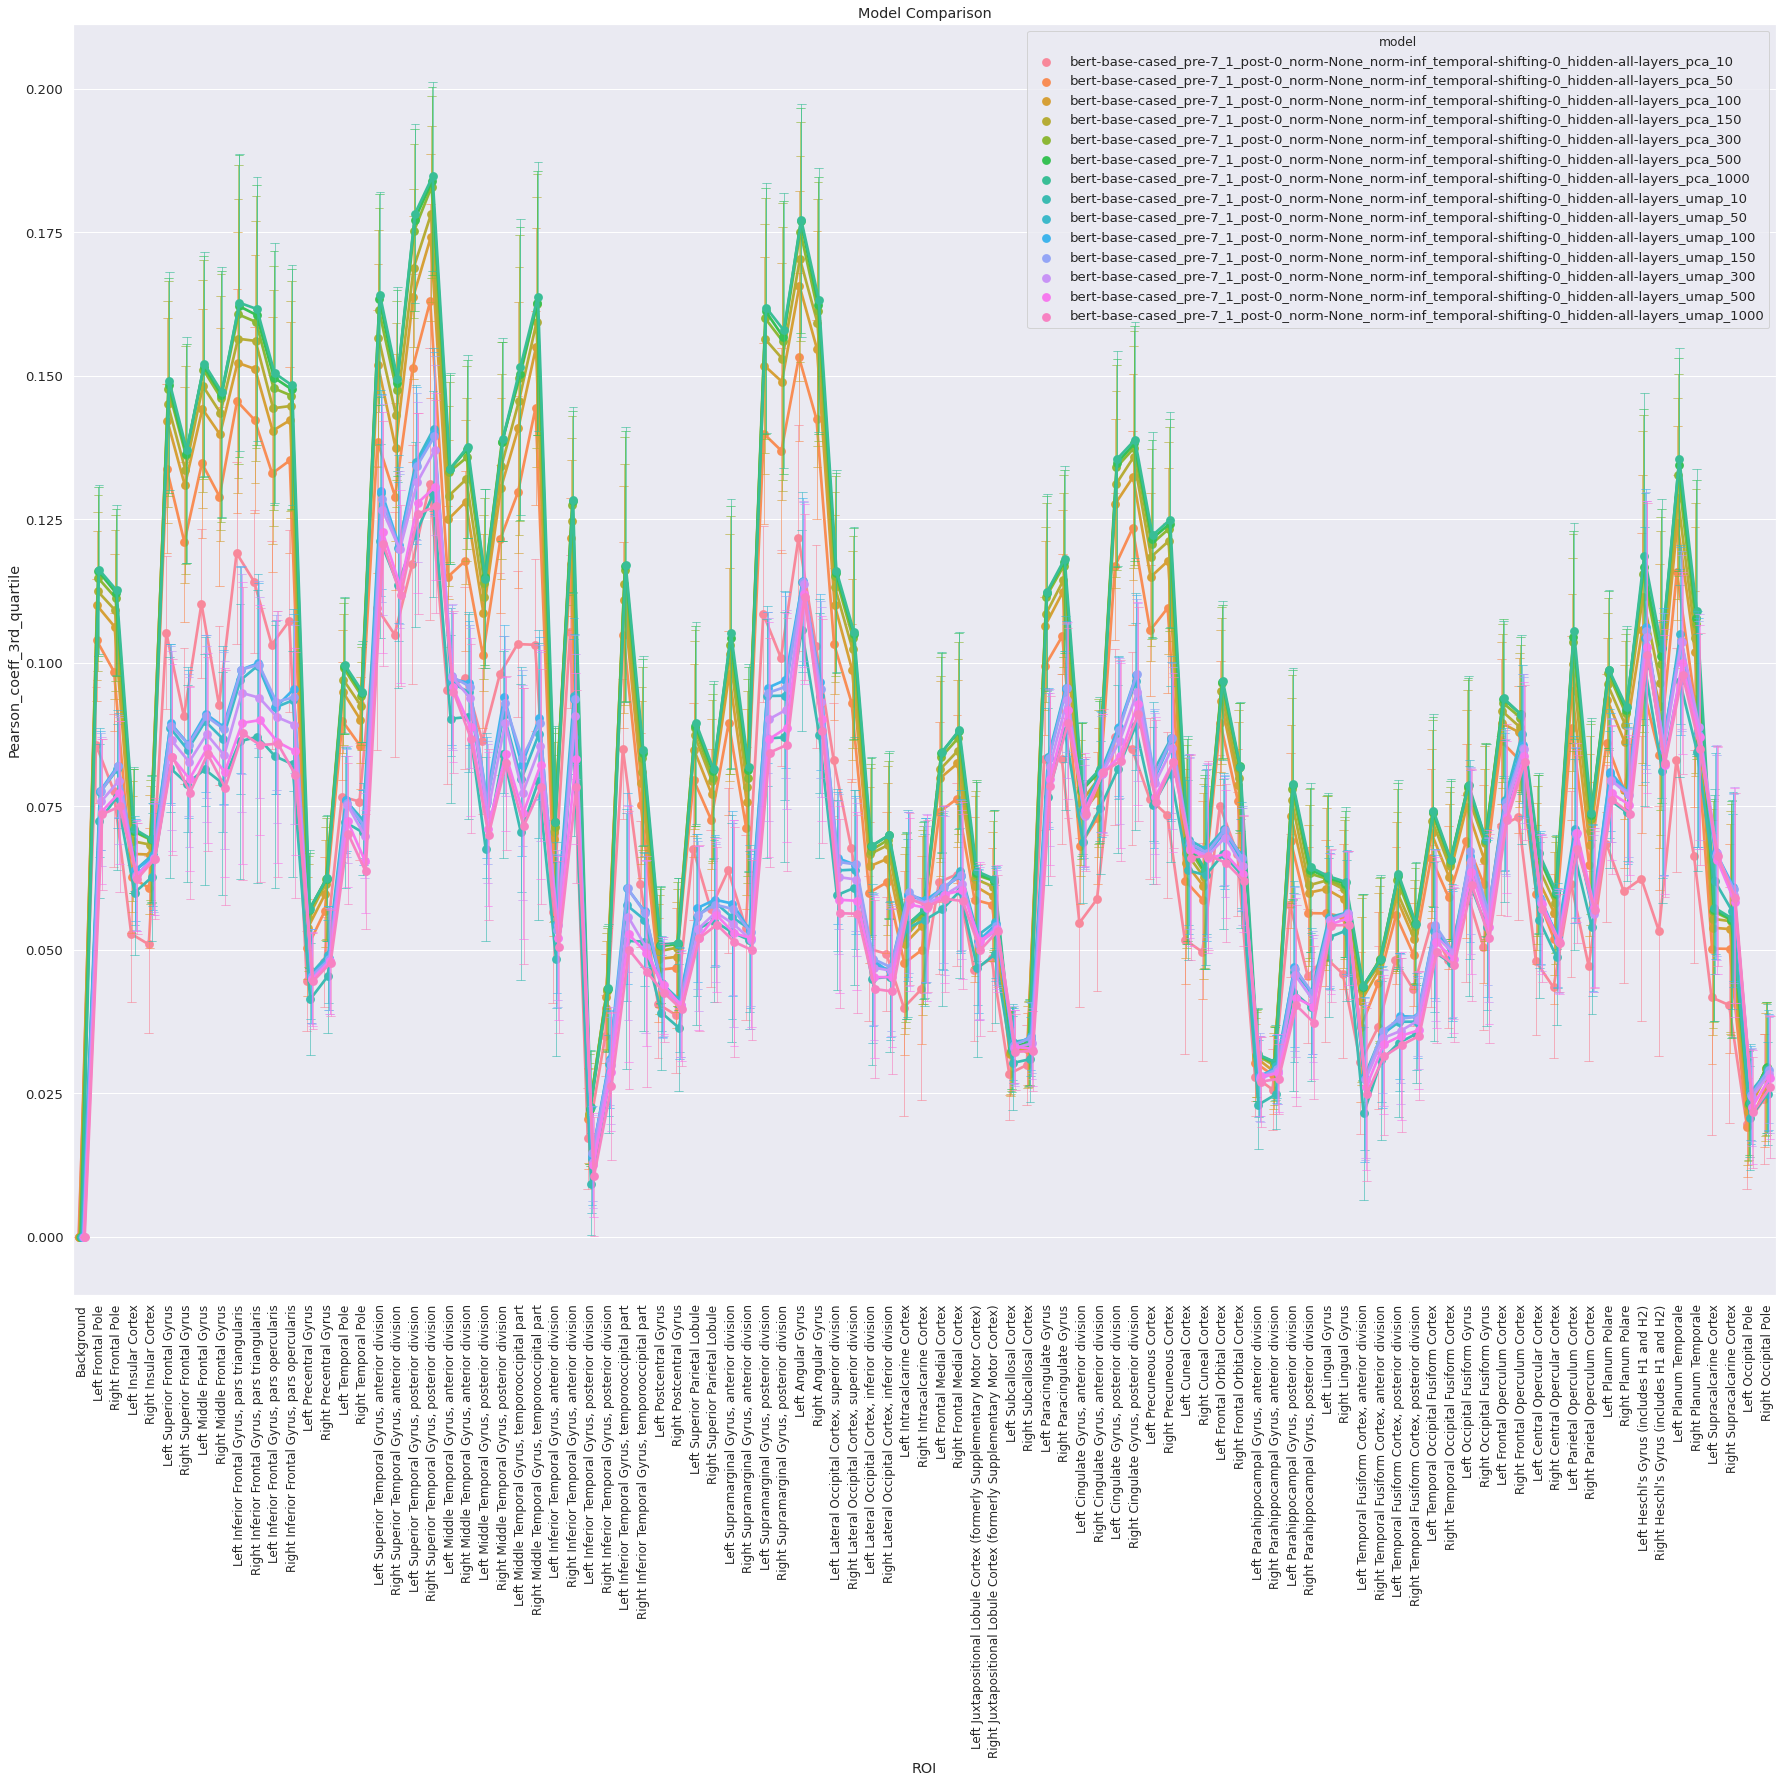

In [18]:
data_tmp = comparison[comparison.apply(lambda x: x['model'] in sub_model_names_pca + sub_model_names_umap , axis=1)].reset_index(drop=True)
for roi in tqdm(data_tmp['ROI'].unique()):
    mean_global = np.mean(data_tmp[data_tmp['ROI']==roi]['Pearson_coeff_3rd_quartile'].values)
    for subject in data_tmp['subject'].unique():
        tmp = mean_global - np.mean(data_tmp[(data_tmp['ROI']==roi) & (data_tmp['subject']==subject)]['Pearson_coeff_3rd_quartile'].values)
        data_tmp.loc[(data_tmp['ROI']==roi) & (data_tmp['subject']==subject),'Pearson_coeff_3rd_quartile'] += tmp

plt.figure(figsize=((25,25)))
sns.set(context='notebook', font_scale=1.2)
colors = ['r', 'g', 'blue', 'black']
#for index, model in enumerate(anova_comparison['model'].unique()):
#    sns.pointplot(data=anova_comparison[anova_comparison['model']==model], x='ROI', y='Pearson_coeff_3rd_quartile', alpha=0.7, errwidth=0.6, capsize=.1, ci='sd', color=colors[index])
sns.pointplot(data=data_tmp, x='ROI', y='Pearson_coeff_3rd_quartile', hue='model', dodge=True, alpha=0.7, errwidth=0.6, capsize=0.5, ci='sd')

_ = plt.title('Model Comparison')
ax = plt.axes()
ax.tick_params(axis='x', labelsize=12, rotation=90)
#plt.legend([model], ncol=1, bbox_to_anchor=(0,0,1,1), fontsize=10)
#plt.legend(anova_comparison['model'].unique(), ncol=1, bbox_to_anchor=(0,0,1,1), fontsize=10)

plt.tight_layout()
plt.show()

100%|██████████| 97/97 [00:45<00:00,  2.15it/s]


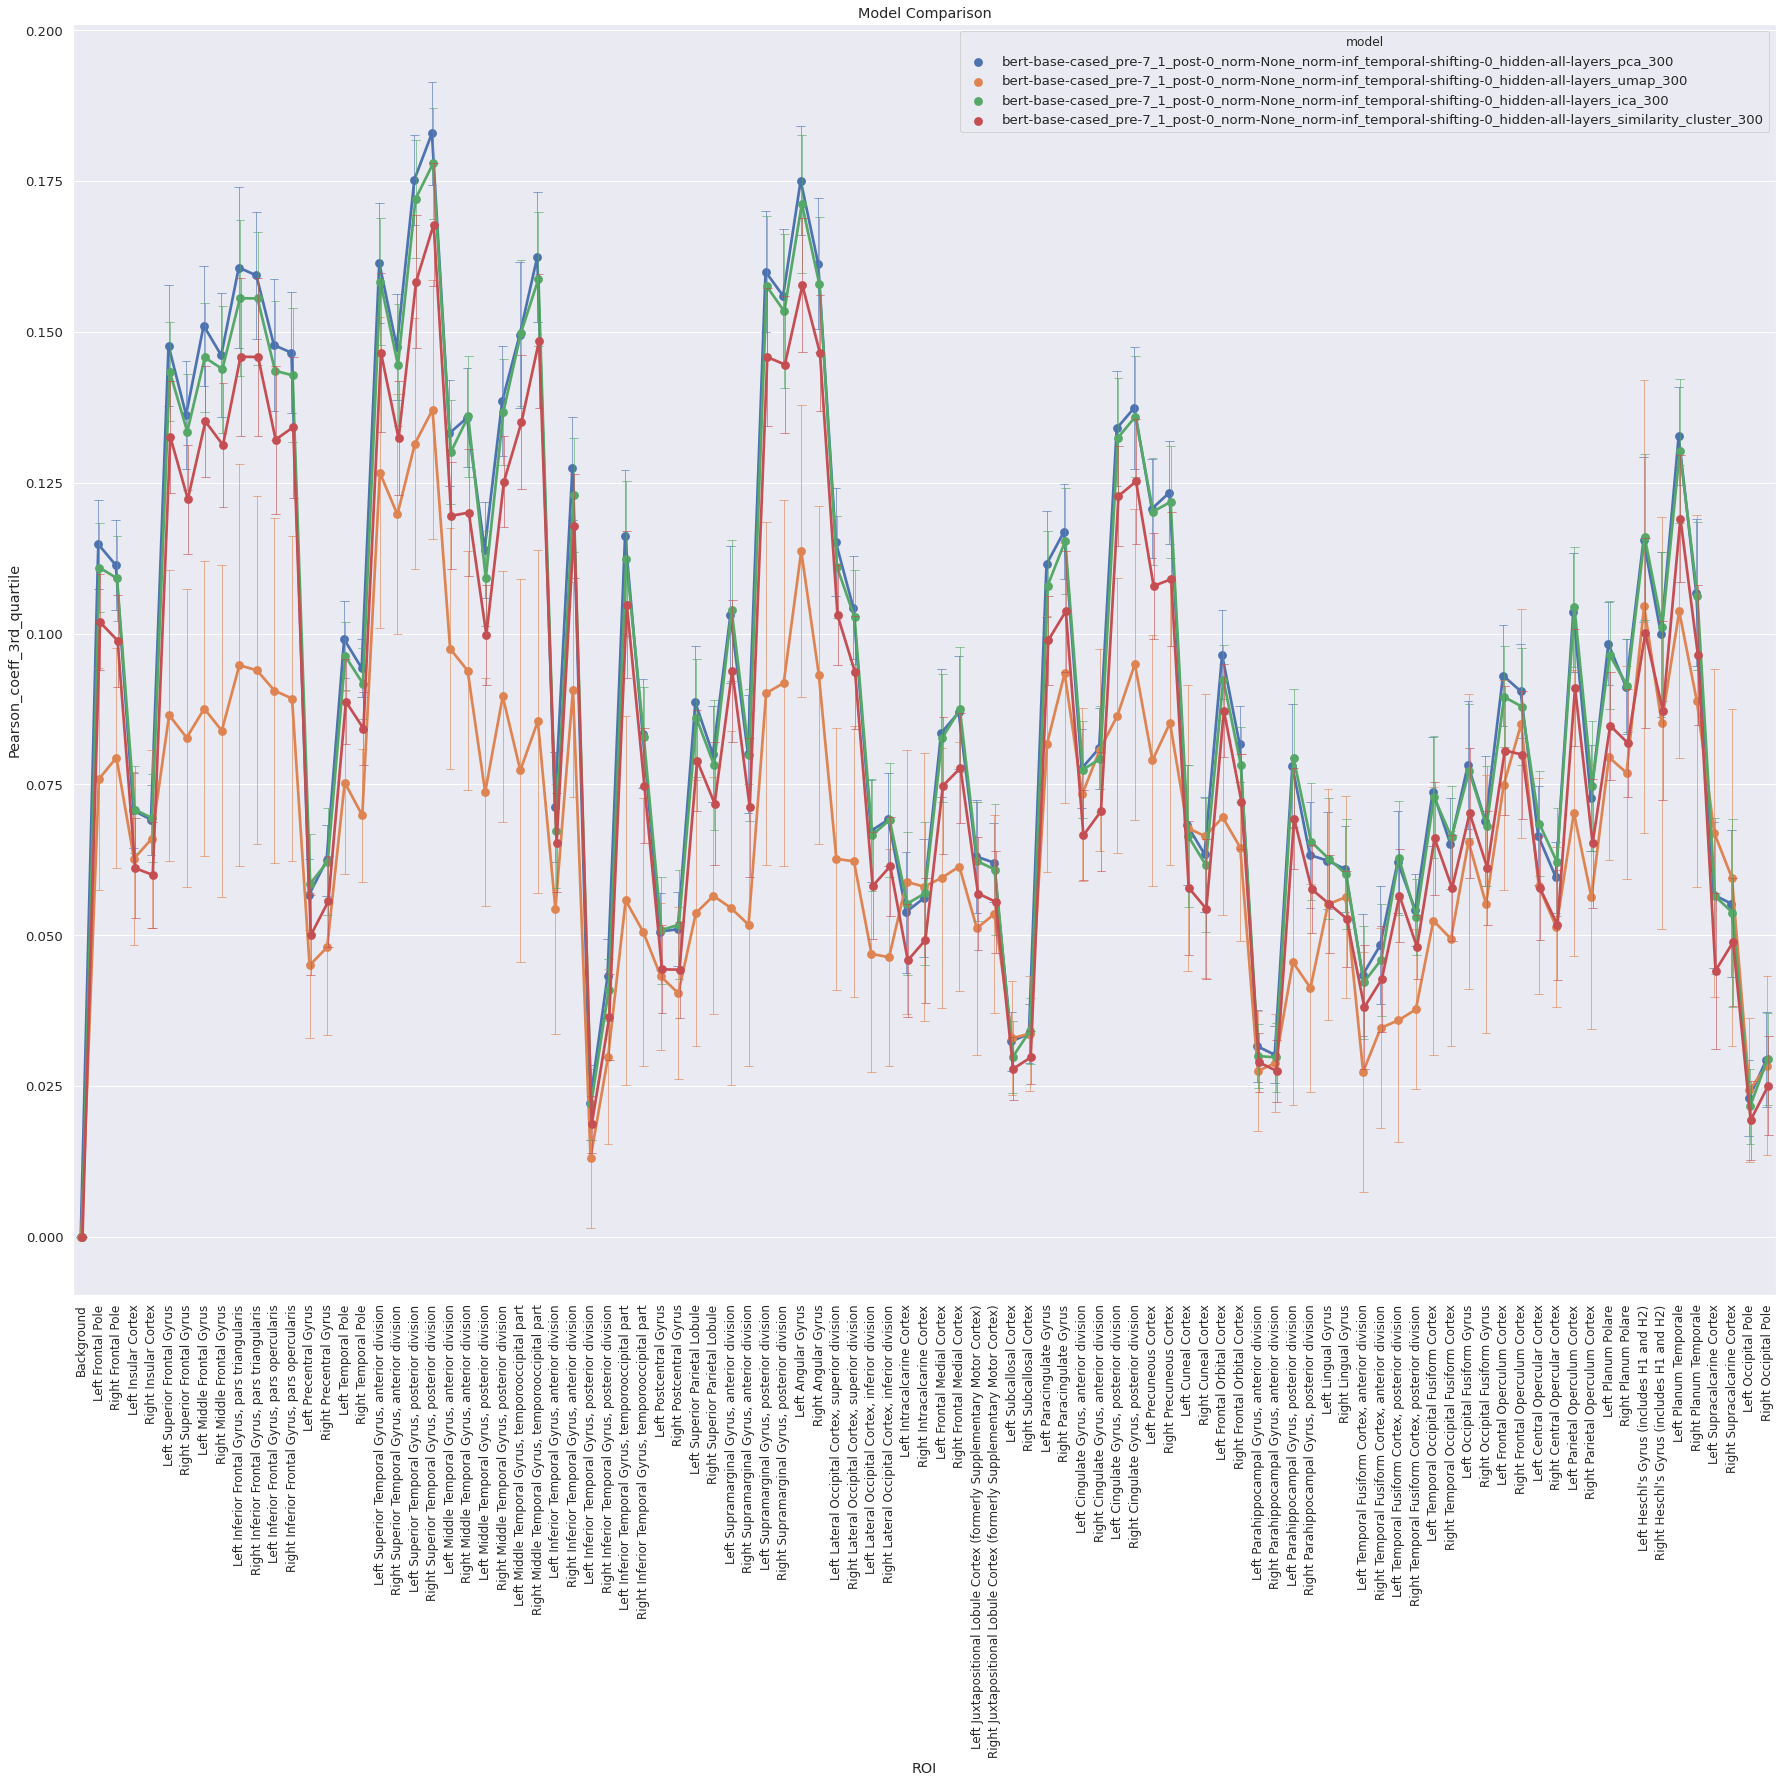

In [17]:

data_tmp = comparison[comparison.apply(lambda x: x['model'] in sub_model_names, axis=1)].reset_index(drop=True)
for roi in tqdm(data_tmp['ROI'].unique()):
    mean_global = np.mean(data_tmp[data_tmp['ROI']==roi]['Pearson_coeff_3rd_quartile'].values)
    for subject in data_tmp['subject'].unique():
        tmp = mean_global - np.mean(data_tmp[(data_tmp['ROI']==roi) & (data_tmp['subject']==subject)]['Pearson_coeff_3rd_quartile'].values)
        data_tmp.loc[(data_tmp['ROI']==roi) & (data_tmp['subject']==subject),'Pearson_coeff_3rd_quartile'] += tmp

plt.figure(figsize=((25,25)))
sns.set(context='notebook', font_scale=1.2)
colors = ['r', 'g', 'blue', 'black']
#for index, model in enumerate(anova_comparison['model'].unique()):
#    sns.pointplot(data=anova_comparison[anova_comparison['model']==model], x='ROI', y='Pearson_coeff_3rd_quartile', alpha=0.7, errwidth=0.6, capsize=.1, ci='sd', color=colors[index])
sns.pointplot(data=data_tmp, x='ROI', y='Pearson_coeff_3rd_quartile', hue='model', dodge=True, alpha=0.7, errwidth=0.6, capsize=0.5, ci='sd')

_ = plt.title('Model Comparison')
ax = plt.axes()
ax.tick_params(axis='x', labelsize=12, rotation=90)
#plt.legend([model], ncol=1, bbox_to_anchor=(0,0,1,1), fontsize=10)
#plt.legend(anova_comparison['model'].unique(), ncol=1, bbox_to_anchor=(0,0,1,1), fontsize=10)

plt.tight_layout()
plt.show()

We observe that keeping more than 300 components with the PCA is not necessary, as similar (averaged per ROI) results are achieved.

### PCA explained variance

In [13]:
model_name = 'roberta-base_pre-10_1_post-0_norm-None'  # 'gpt2_pre-0_1_norm-inf', 'bert-base-cased_pre-7_1_post-0_norm-None'
plot_name = 'ROBERTA (pre-10) PCA' #'BERT PCA'

In [14]:
paths = sorted(glob.glob(os.path.join(INPUT_PATH, model_name, 'activation*')))

In [ ]:
data = [pd.read_csv(path) for path in paths]

We only keep hidden states values:

In [ ]:
dataframes = [d[d.keys()[:13*768]] for d in data]

In [ ]:
X = [df.values for df in dataframes]

In [ ]:
reporting.explained_variance(X, plot_name, n_components_max=1000, n_components_to_plot=[10, 50, 100, 150, 300, 500, 1000], saving_path=None)


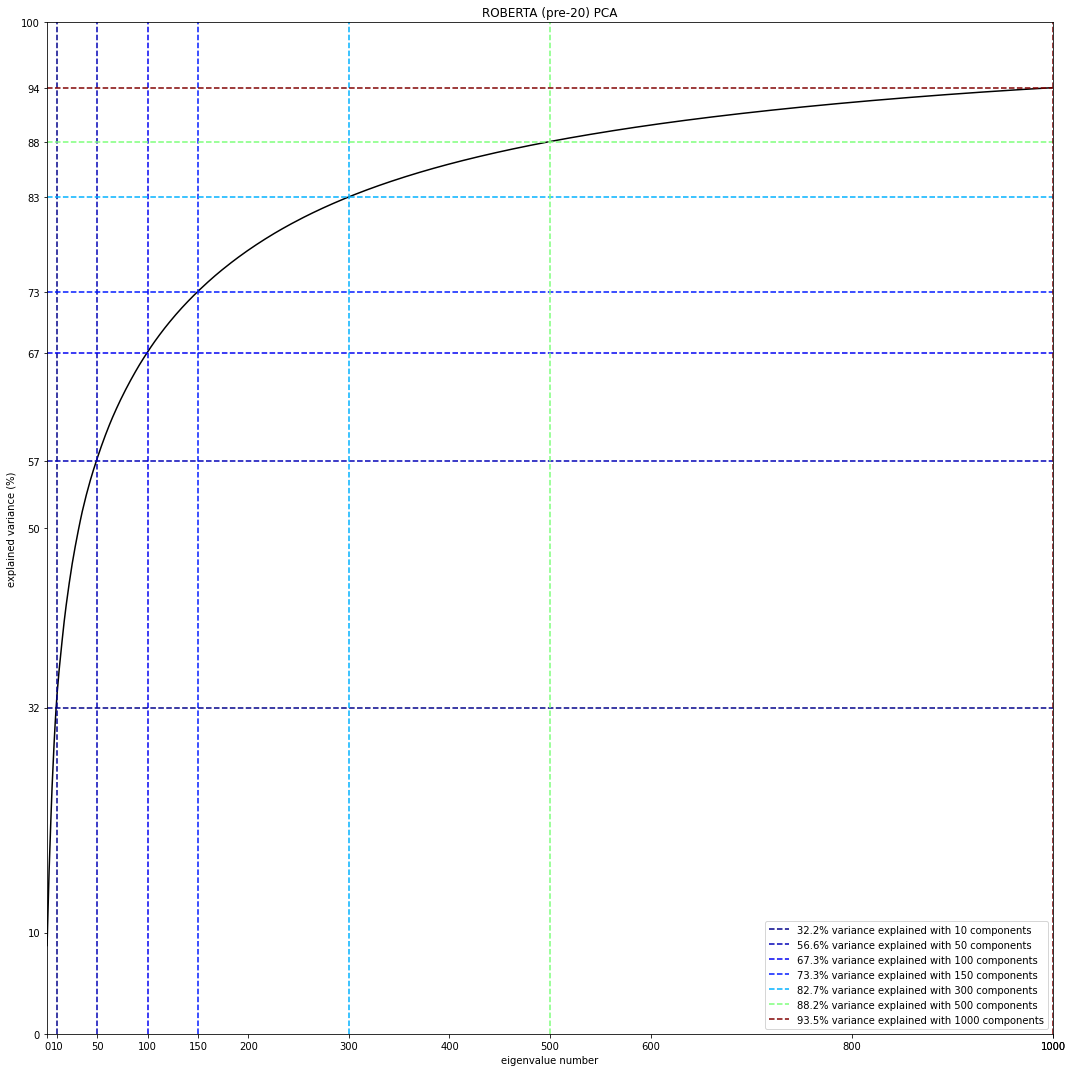

In [12]:
reporting.explained_variance(X, plot_name, n_components_max=1000, n_components_to_plot=[10, 50, 100, 150, 300, 500, 1000], saving_path=None)


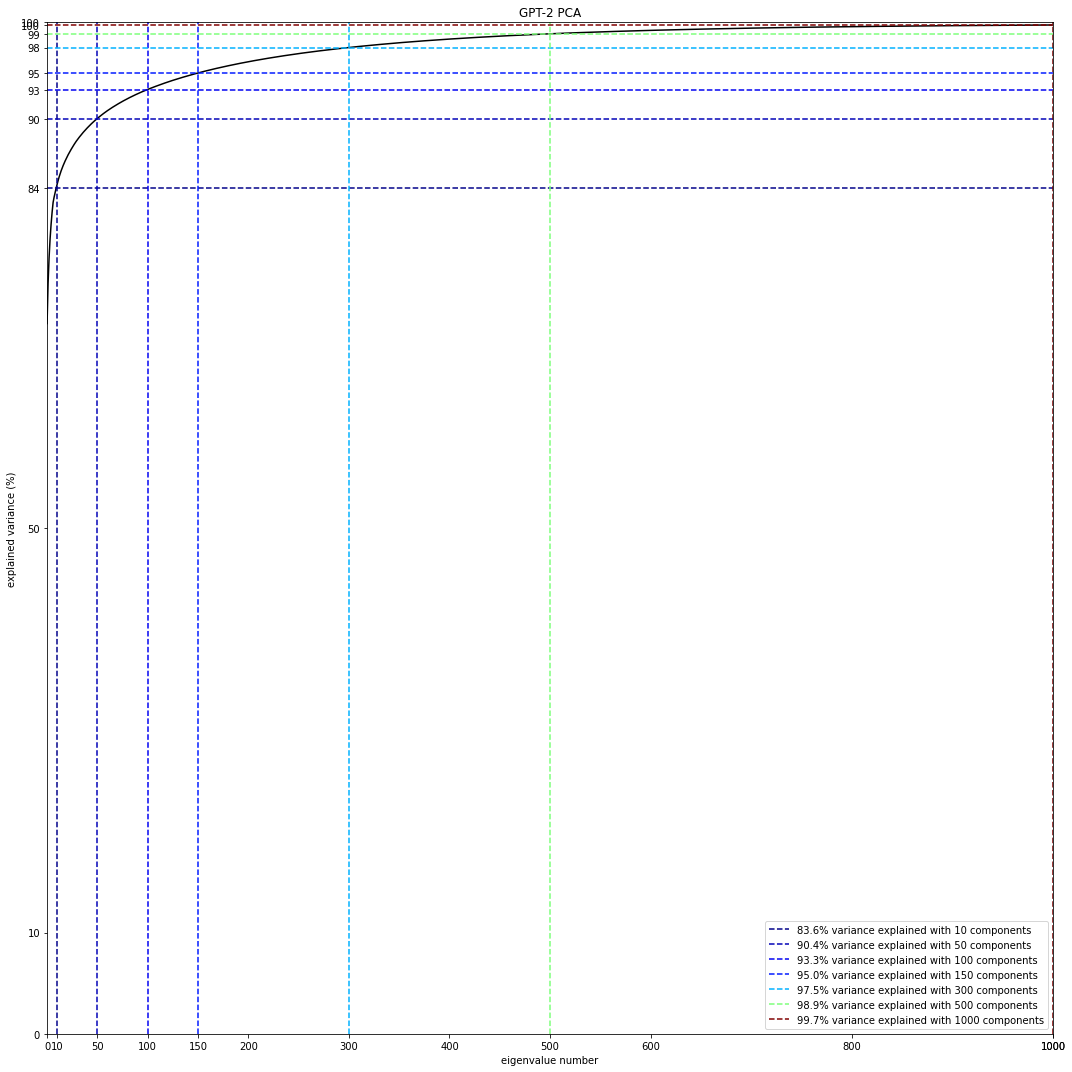

In [13]:
reporting.explained_variance(X, plot_name, n_components_max=1000, n_components_to_plot=[10, 50, 100, 150, 300, 500, 1000], saving_path=None)

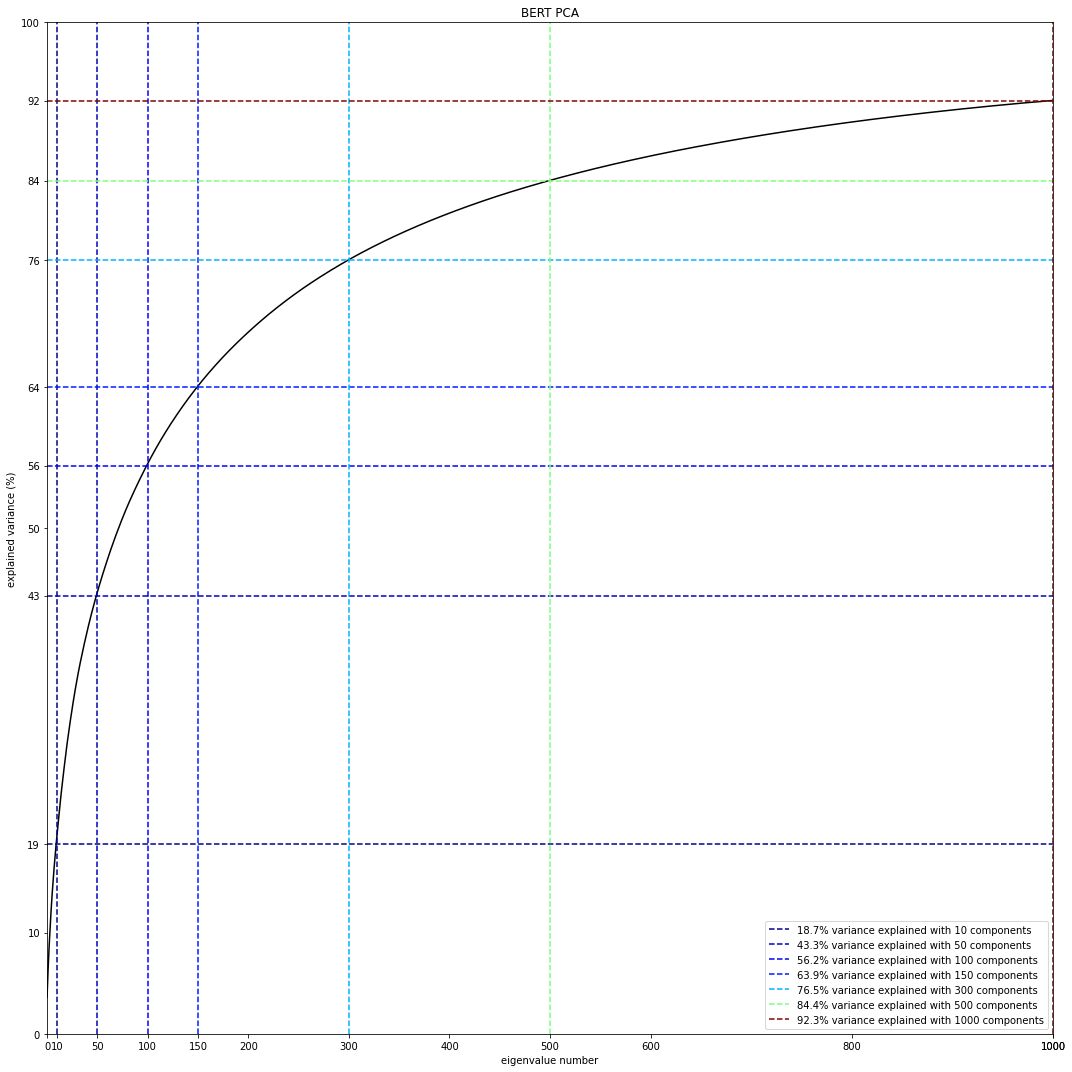

In [22]:
reporting.explained_variance(X, plot_name, n_components_max=1000, n_components_to_plot=[10, 50, 100, 150, 300, 500, 1000], saving_path=None)